# 📍CNN
'모두를 위한 딥러닝2'의 'Lab10 CNN'을 듣고 정리한 코드입니다.  

* 강의 링크: https://www.youtube.com/watch?v=rySyghVxo6U&list=PLQ28Nx3M4JrhkqBVIXg-i5_CVVoS1UzAv&index=19
* 블로그 링크: https://gaga.tistory.com/215

## 1. Convolution

## Terms
### Convolution
이미지 위에서 stride 값만큼 filter(kernel)을 이동시키면서 겹쳐지는 부분의 각 원소의 값을 곱해서 모두 더한 값을 출력으로 하는 연산 
  
### Stride
kernel(stride)의 이동 범위를 stride  

  
### Padding
패딩은 합성곱 연산을 하기 전에 입력의 가장자리에 지정된 개수의 폭만큼 행과 열을 추가해주는 것   
zero-padding

### Pooling
image의 size를 줄이기 위해서 사용한다.
fully connected 연산을 대체하기 위해서 average pooling을 사용하기도 한다. Pooling layer에서는 따로 학습값이 진행되지 않고, backpropagation 값을 그대로 전달해준다.
* max pooling
* average pooling

### PyTorch nn.Conv2d 
* intput type: torch.Tensor
* intput shape: (N * C * H * W)  
                (batch_size, channel, height, width)
* output size:
소수점이 나올 경우에는 소수점을 버림하면 된다.
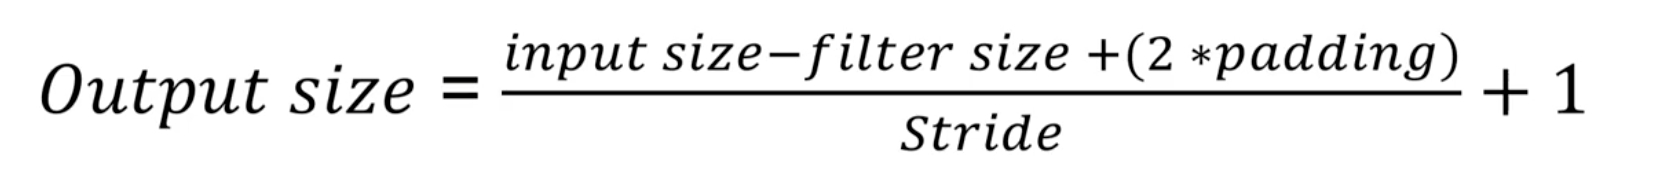

### PyTorch nn.MaxPool2d
MaxPooling    
정수 하나를 인자로 넣으면 커널 사이즈와 스트라이드가 둘 다 해당값으로 지정

## CNN Implementation

In [1]:
import torch
import torch.nn as nn

In [4]:
input = torch.Tensor(1, 1, 28, 28)
conv1 = nn.Conv2d(1, 5, 5)
pool = nn.MaxPool2d(2)
out = conv1(input)
print("conv1.shape:", out.shape)
out = pool(out)
print("pool.shape:", out.shape)

conv1.shape: torch.Size([1, 5, 24, 24])
pool.shape: torch.Size([1, 5, 12, 12])


In [8]:
# 첫 번째 차원인 배치 차원은 그대로 두고 나머지는 펼쳐라
out = out.view(out.size(0), -1)
print(out.shape)

torch.Size([1, 720])


In [9]:
# funnly connected layer 통과
fc = nn.Linear(720, 10)
out = fc(out)
print(out.shape)

torch.Size([1, 10])


### Cross-correlation
Convolution(합성곱)은 하나의 함수와 또 다른 함수를 반전 이동한 값을 곱한 다음, 구간에 대해 적분하여 새로운 함수를 구하는 수학 연산자이다. 즉, 쉽게 말하면 Convolution은 뒤집고 계산한다.    
  
Cross-correlation은(교차상관) Convolution과 동일하지만, 함수를 반전하지 않고 게산한다. 즉, 뒤집지 않고 계산한다.  
  
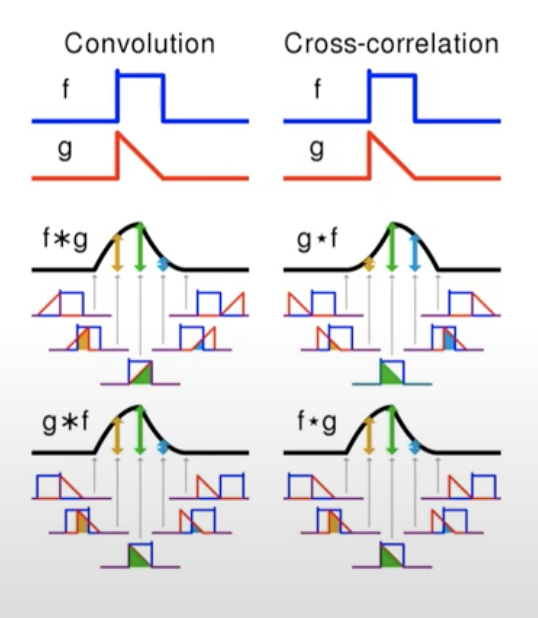

## 2. MNIST CNN
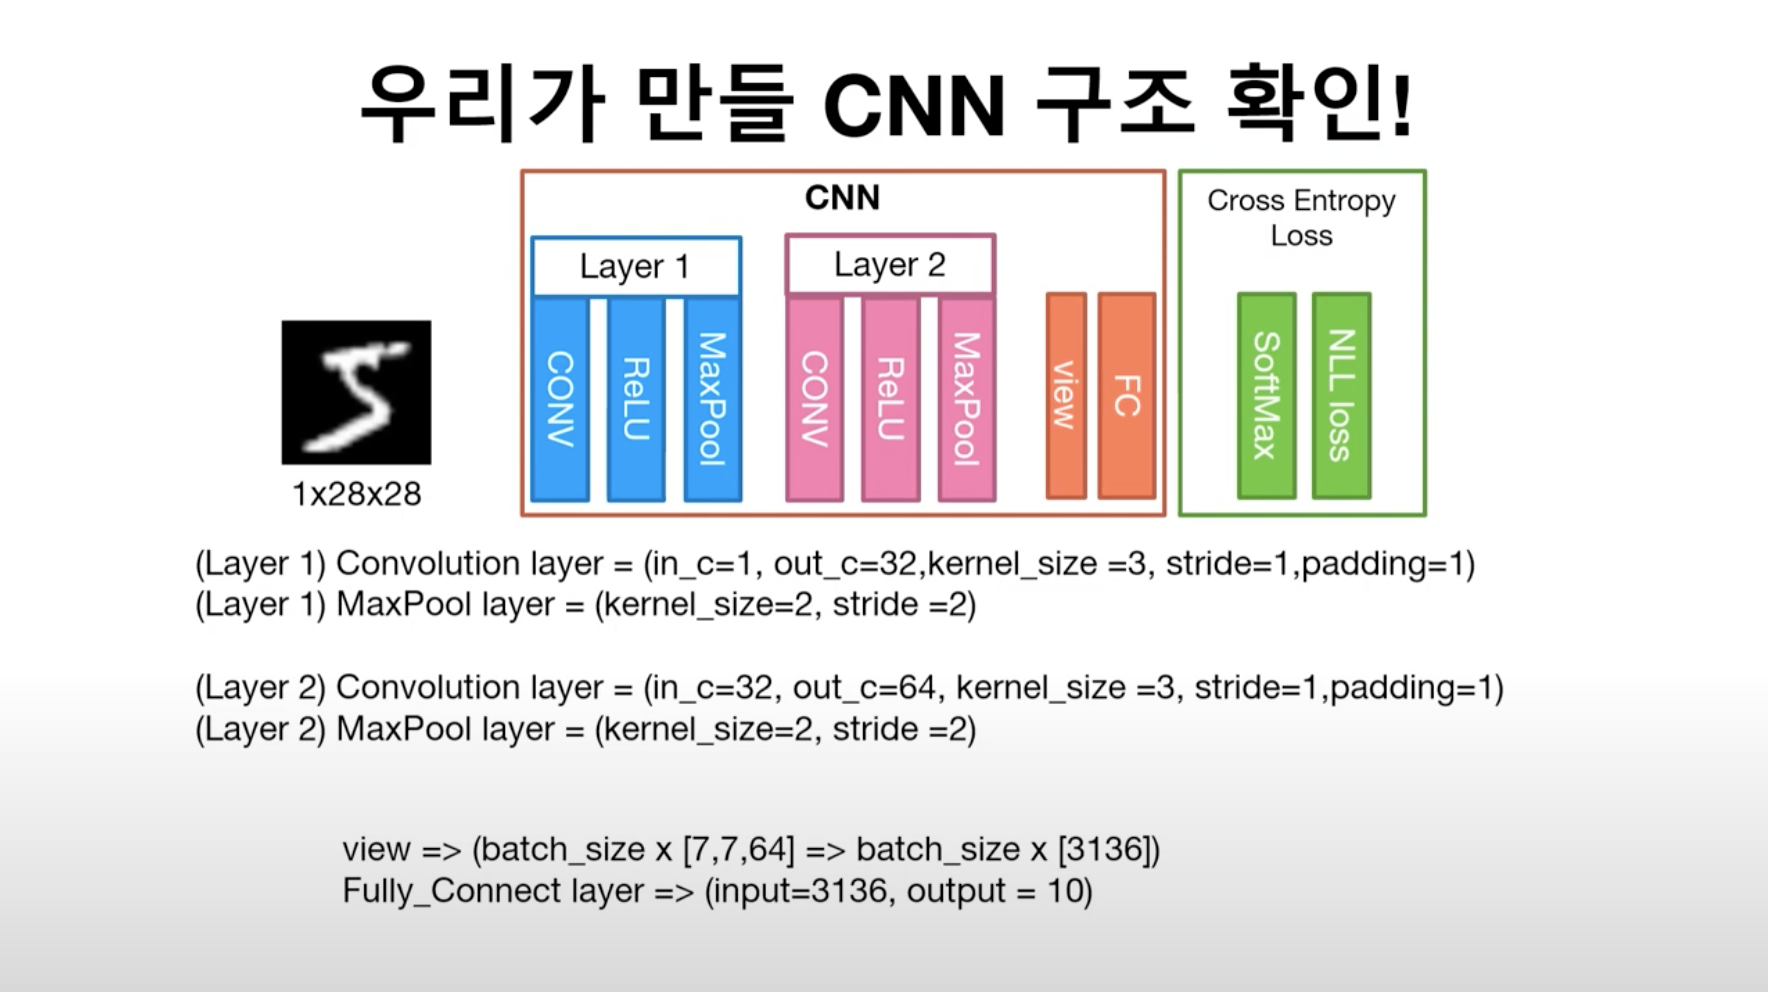

In [11]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

import random

In [12]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [13]:
# for reproducibility
random.seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [14]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [15]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [16]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = nn.Linear(7*7*64, 10, bias=True)
        
        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.view(out.size(0), -1) # 전결합층을 위해서 Flatten
        out = self.fc(out)
        
        return out

In [18]:
model = CNN().to(device)

In [19]:
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [20]:
# loss & optimizer
criterion = nn.CrossEntropyLoss().to(device) # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
# training
total_batch = len(data_loader) # 전체 배치 사이즈

for epoch in range(training_epochs):
    avg_cost = 0
    
    for X, Y in data_loader:
        X = X.to(device) # input
        Y = Y.to(device) # label
        
        optimizer.zero_grad() # 이것을 빼먹으면 학습이 아예 안된다.
        hypothesis = model(X)
        
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    
    print("[Epoch {}] cost = {}".format(epoch+1, avg_cost))
    
print("Learning Finished!")

[Epoch 1] cost = 0.22372950613498688
[Epoch 2] cost = 0.061761487275362015
[Epoch 3] cost = 0.04565168544650078
[Epoch 4] cost = 0.03716575354337692
[Epoch 5] cost = 0.029896635562181473
[Epoch 6] cost = 0.025620073080062866
[Epoch 7] cost = 0.021339567378163338
[Epoch 8] cost = 0.0177732203155756
[Epoch 9] cost = 0.015331296250224113
[Epoch 10] cost = 0.013325252570211887
[Epoch 11] cost = 0.011781617999076843
[Epoch 12] cost = 0.009246794506907463
[Epoch 13] cost = 0.0087473439052701
[Epoch 14] cost = 0.007278901059180498
[Epoch 15] cost = 0.006516996771097183
Learning Finished!


In [22]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1,28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print("Accuracy:", accuracy.item())

/Users/shimgahyeon/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/shimgahyeon/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9886999726295471


## 3. 깊은 CNN으로 MNIST 분류
#### Layer 3, 4, 5 추가
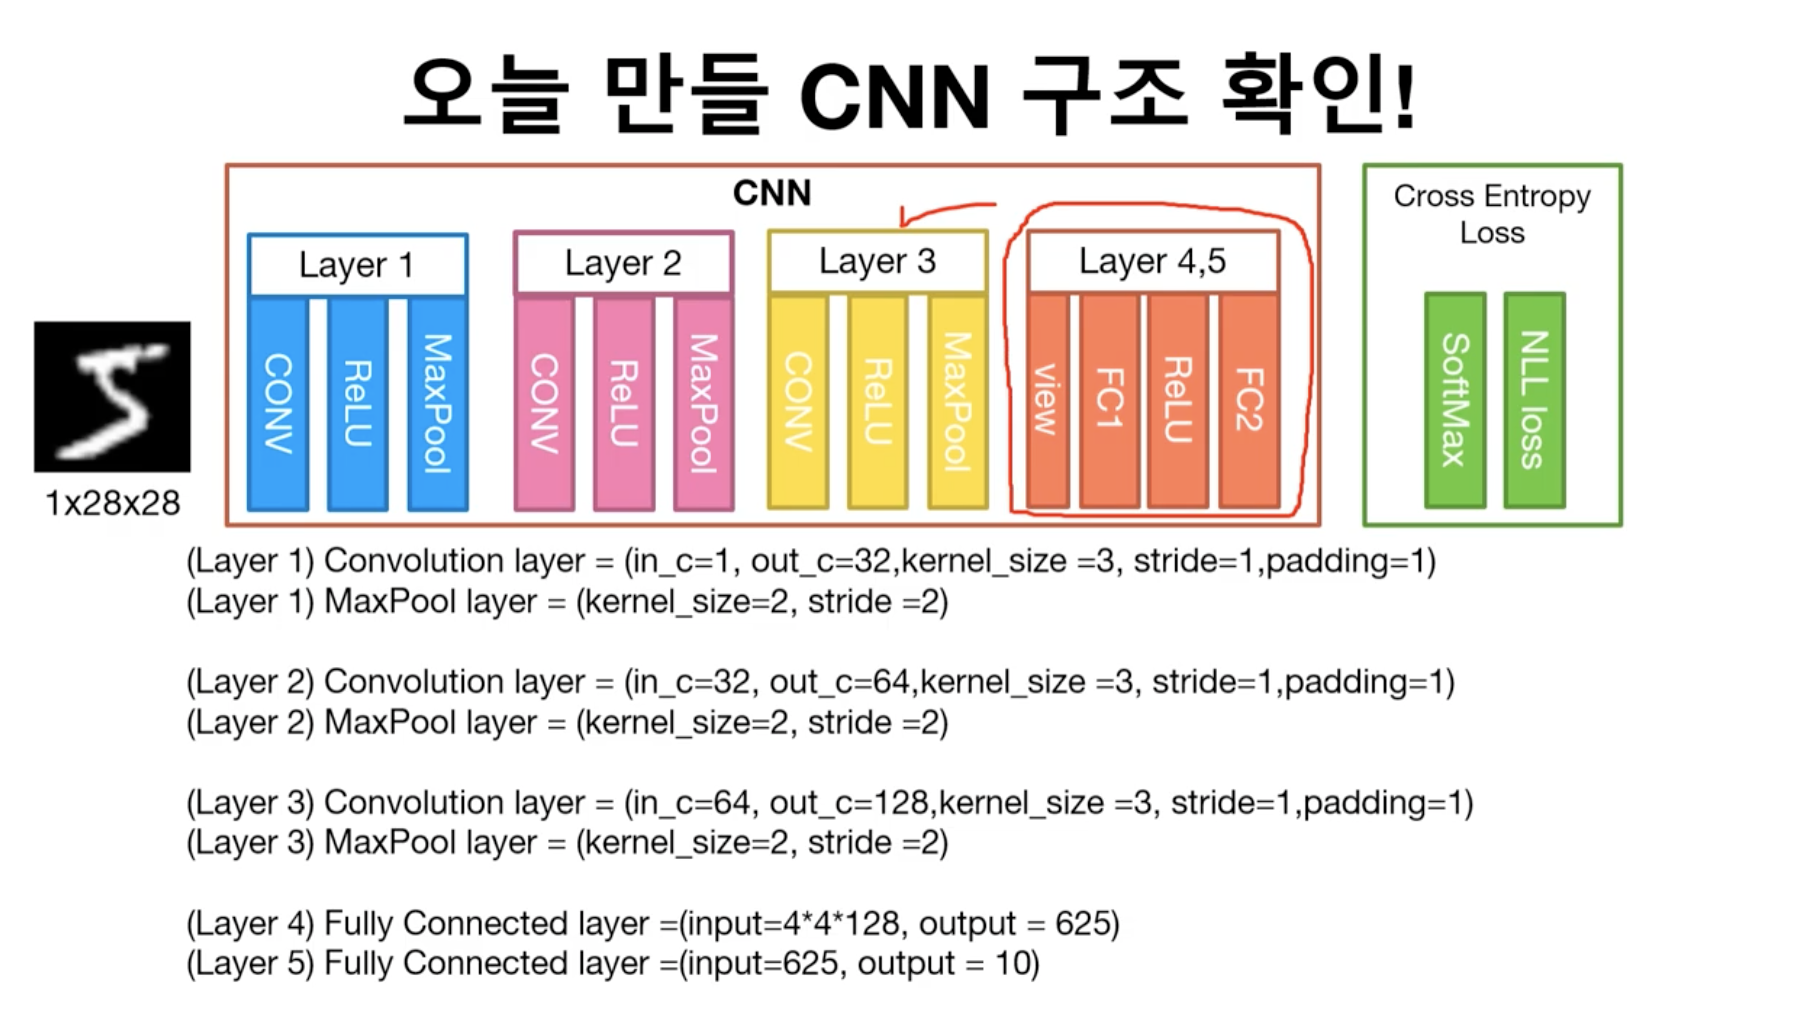

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1= nn.Linear(3*3*128, 625)
        self.relu = nn.ReLU()
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [26]:
model = CNN().to(device)

In [28]:
# 모델 테스트
value = torch.Tensor(1, 1, 28, 28).to(device)
print((model(value)).shape)

torch.Size([1, 10])


In [29]:
# training
total_batch = len(data_loader) # 전체 배치 사이즈

for epoch in range(training_epochs):
    avg_cost = 0
    
    for X, Y in data_loader:
        X = X.to(device) # input
        Y = Y.to(device) # label
        
        optimizer.zero_grad() # 이것을 빼먹으면 학습이 아예 안된다.
        hypothesis = model(X)
        
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    
    print("[Epoch {}] cost = {}".format(epoch+1, avg_cost))
    
print("Learning Finished!")

[Epoch 1] cost = 2.3053030967712402
[Epoch 2] cost = 2.3053009510040283
[Epoch 3] cost = 2.305302619934082
[Epoch 4] cost = 2.3053014278411865
[Epoch 5] cost = 2.305300712585449
[Epoch 6] cost = 2.305299997329712
[Epoch 7] cost = 2.3053009510040283
[Epoch 8] cost = 2.3052995204925537
[Epoch 9] cost = 2.3053019046783447
[Epoch 10] cost = 2.305302619934082
[Epoch 11] cost = 2.3053030967712402
[Epoch 12] cost = 2.305302858352661
[Epoch 13] cost = 2.305302381515503
[Epoch 14] cost = 2.3053011894226074
[Epoch 15] cost = 2.305302858352661
Learning Finished!


모델의 층을 깊게 쌓는다고 해서 항상 모델의 정확도가 올라가지는 않는다. 모델의 층을 깊고 "효율적으로" 쌓아햐 한다.

In [30]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1,28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print("Accuracy:", accuracy.item())

Accuracy: 0.13120000064373016
